# Exercise 7



In [ ]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import networkx as nx

In [38]:
def total_distance(coords, route):
    dist = 0.0
    n = len(route)
    for i in range(n):
        j = (i + 1) % n
        p1 = coords[route[i]]
        p2 = coords[route[j]]
        dist += np.linalg.norm(p1 - p2)
    return dist


In [39]:
def simulated_annealing(coords, T_schedule, max_iter=10000):
    n = len(coords)
    # Initialize with a random route
    route = list(range(n))
    random.shuffle(route)
    best_route = route.copy()
    best_cost = total_distance(coords, route)
    current_cost = best_cost

    for k in range(max_iter):
        T = T_schedule(k)
        # Propose swap of two stations
        i, j = random.sample(range(n), 2)
        new_route = route.copy()
        new_route[i], new_route[j] = new_route[j], new_route[i]
        new_cost = total_distance(coords, new_route)
        delta = new_cost - current_cost
        # Accept if better or with probability exp(-delta/T)
        if delta < 0 or math.exp(-delta / T) > random.random():
            route = new_route
            current_cost = new_cost
            if new_cost < best_cost:
                best_cost = new_cost
                best_route = new_route.copy()
    return best_route, best_cost


In [40]:
# Define cooling schedule: T_k = 1/sqrt(1+k)
def cooling_schedule(k):
    return 1.0 / math.sqrt(1 + k)


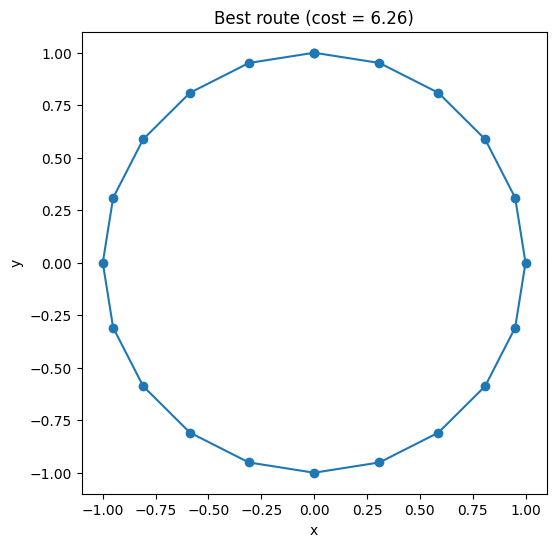

In [41]:
# Debug with stations on a circle
n = 20
angles = np.linspace(0, 2 * math.pi, n, endpoint=False)
coords = np.column_stack((np.cos(angles), np.sin(angles)))
best_route, best_cost = simulated_annealing(coords, cooling_schedule, max_iter=10000)

# Plot the resulting route
route_cycle = best_route + [best_route[0]]
route_coords = coords[route_cycle]
plt.figure(figsize=(6, 6))
plt.plot(route_coords[:, 0], route_coords[:, 1], 'o-')
plt.title(f'Best route (cost = {best_cost:.2f})')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [42]:
def route_cost_matrix(route, cost_matrix):
    n = len(route)
    return sum(
        cost_matrix[route[i], route[(i + 1) % n]]
        for i in range(n)
    )


In [43]:
def simulated_annealing_cost(cost_matrix, T_schedule, max_iter=10000):
    n = cost_matrix.shape[0]
    route = list(range(n))
    random.shuffle(route)
    best_route = route.copy()
    best_cost = route_cost_matrix(route, cost_matrix)
    current_cost = best_cost

    for k in range(max_iter):
        T = T_schedule(k)
        i, j = random.sample(range(n), 2)
        new_route = route.copy()
        new_route[i], new_route[j] = new_route[j], new_route[i]
        new_cost = route_cost_matrix(new_route, cost_matrix)
        delta = new_cost - current_cost
        if delta < 0 or math.exp(-delta / T) > random.random():
            route = new_route
            current_cost = new_cost
            if new_cost < best_cost:
                best_cost = new_cost
                best_route = new_route.copy()
    return best_route, best_cost


In [44]:
cost_matrix = np.loadtxt('cost.csv', delimiter=',')
best_route_mat, best_cost_mat = simulated_annealing_cost(cost_matrix, cooling_schedule, max_iter=10000)
print('Best route:', best_route_mat)
print('Best cost:', best_cost_mat)

Best route: [5, 11, 12, 3, 4, 13, 8, 1, 14, 18, 17, 16, 9, 15, 7, 6, 10, 19, 2, 0]
Best cost: 1294.0


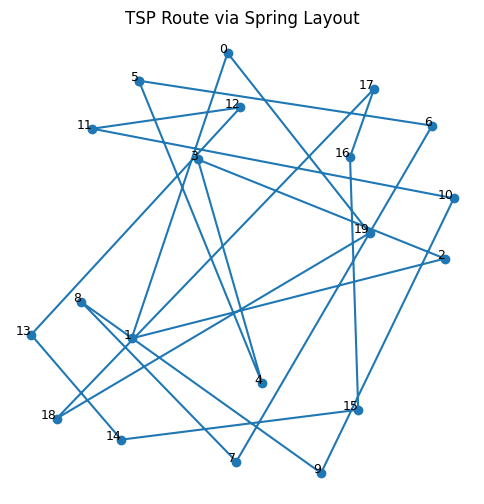

In [45]:
# build graph
n = cost_matrix.shape[0]
G = nx.Graph()
for i in range(n):
    for j in range(i+1, n):
        # higher cost -> weaker attraction
        G.add_edge(i, j, weight=1.0/(cost_matrix[i,j] + 1e-6))

# compute spring layout
pos = nx.spring_layout(G, weight='weight', seed=42)

# extract XY coordinates in tour order
route_cycle = best_route + [best_route[0]]
coords_xy = np.array([pos[i] for i in route_cycle])

# plot
plt.figure(figsize=(6,6))
plt.plot(coords_xy[:,0], coords_xy[:,1], 'o-', linewidth=1.5)
for idx,(x,y) in enumerate(coords_xy[:-1]):
    plt.text(x, y, str(route_cycle[idx]), fontsize=9, ha='right')
plt.title('TSP Route via Spring Layout')
plt.axis('off')
plt.show()